In [1]:
import numpy as np
import matplotlib.pyplot as plt


from hnc_newton import  HNC_solver
from qsps import *


# Two Species

Here we do QSP interactions between electrons and one ion type. 

Using $\tilde{r}\equiv r/r_s$, we implement potentials 
\begin{align}
\beta v_{ee}(\tilde{r}) &=  \frac{\Gamma_{ee}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right) +  \ln2 \exp\left[-\tilde{r}^2 r_s^2/(\pi \Lambda_e^2 \ln 2)\right]\\
\beta v_{ei}(\tilde{r}) &=  \frac{\Gamma_{ei}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right)\\
\beta v_{ii}(\tilde{r}) &=  \frac{\Gamma_{ii}}{\tilde{r}}
\end{align}
For  
\begin{align}
\Gamma_{ee}&=\frac{\beta e^2}{r_s}\\
\Gamma_{ei}&=\frac{\beta Z_i e^2}{r_s}\\
\Gamma_{ii}&=\frac{\beta Z_i^2 e^2}{r_s}\\
\end{align}

Plug into get potentials

In [2]:
# ri = QSP_HNC.rs_from_n(6.03e30*aB**3)
ri = 3
Te_c = 50*eV 
Ti   = 50*eV 
Z, A = 13, 27
Zstar= 3
# "Classical-Map  Hypernetted  Chain  Calculations  for  DensePlasmas"R. Bredow1∗, Th. Bornath1, W.-D. Kraeft1, M.W.C. Dharma-wardana2,andR. Redmer1
# Tq  = 1/5*qsp.E_F 


def make_Te(Te_c, Tq):
    Te  = np.sqrt(Tq**2 + Te_c**2)
    return Te
    
qsp = QSP_HNC(Z, A, Zstar, Te_c, Ti, ri)
# Tq = 200*1/5*qsp.E_F 
# qsp = QSP_HNC(Z, A, Zstar, make_Te(Te_c, Tq), Ti, ri)


Λee = 0.139
Λei = 0.098
Γii=1.633, Γie=-0.544, Γee=0.181 
r_i=3.000
r_e=2.080


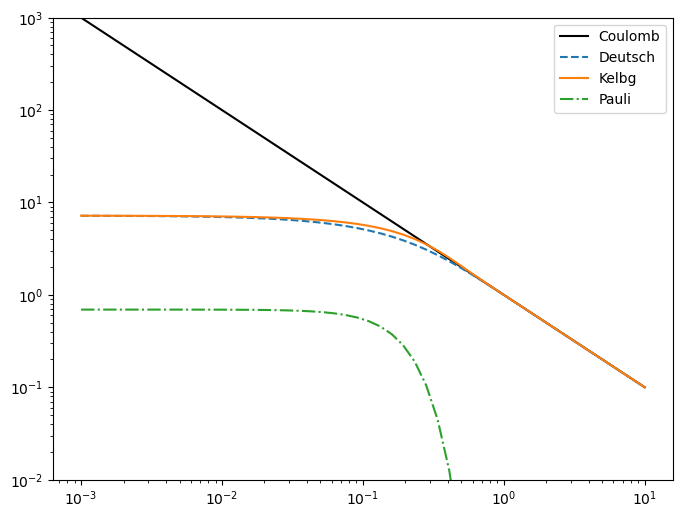

In [3]:

fig, ax = plt.subplots(figsize=(8,6),facecolor='w')

xs = np.geomspace(1e-3,10)
ax.plot(xs, 1/xs,'-k',label='Coulomb')
ax.plot(xs,qsp.βv_Deutsch(1,xs, qsp.Λee),'--',label='Deutsch')
ax.plot(xs,qsp.βv_Kelbg(1,xs,qsp.Λee),label='Kelbg')
ax.plot(xs,qsp.βv_Pauli(xs,qsp.Λee),'-.',label='Pauli')

# ax.plot(xs, qsp.βvee(xs),label='βvee')
# ax.plot(xs, -qsp.βvei(xs),label='-βvei')butt
# ax.plot(xs, -qsp.βvei_atomic(xs),label='-βvei Atomic')
# ax.plot(xs, qsp.βvii(xs),label='βvii')

ax.set_yscale('log')
ax.set_ylim(1e-2,1e3)
ax.set_xscale('log')
ax.legend()

First, we initialize the hnc

In [8]:
N_species = 2
Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                    [qsp.Γei,  qsp.Γee]])


names = ["Ion-1", "Electron", ] 
kappa = 1
rho = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
hnc2 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-8,
                 kappa_multiscale=1, rho = rho, num_iterations=int(1e0), 
                 R_max=5, N_bins=1000, names=names, dst_type=3)


In [9]:
βu_r_matrix = np.array([[qsp.βvii(hnc2.r_array), qsp.βvei(hnc2.r_array)],
                        [qsp.βvei(hnc2.r_array), qsp.βvee(hnc2.r_array)]])

hnc2.set_βu_matrix(βu_r_matrix)
# hnc2.initialize_guess()
hnc2.initialize_c_k()
hnc2.set_C_matrix()
# hnc2.plot_βu_all_species()
# hnc2.HNC_solve(alpha=1e-1, h_max=1e4)

In [10]:
def new_Te(Tq):
    Te = make_Te(Te_c, Tq)
    
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri)
    qsp.Λee*=1
#     qsp.Γ_matrix[0,1]=0
#     qsp.Γ_matrix[1,0]=0
#     qsp.Γei=0
    βvii, βvei, βvee = qsp.βvii(hnc2.r_array), qsp.βvei(hnc2.r_array), qsp.βvee(hnc2.r_array)
    
    
#     qsp = QSP_HNC(Z, A, Zstar, Te_c, Ti, ri)
#     βvei = qsp.βvei(hnc2.r_array)
    βvee = 1*qsp.βvee(hnc2.r_array)
    βvei = 1*qsp.βvei(hnc2.r_array)
    βu_r_matrix = np.array([[βvii, βvei],
                            [βvei, βvee]])

    hnc2.Gamma = qsp.Γ_matrix
    hnc2.set_βu_matrix(βu_r_matrix)
    hnc2.initialize_c_k()
    hnc2.set_C_matrix()

    hnc2.num_iterations=100
    print("Te_c = {0:.3f} eV".format(Te_c/eV))
    print("Tq = {0:.3f} eV".format(Tq/eV))
    print("Te = {0:.3f} eV".format(Te/eV))

Tq = qsp.E_F/(1.594 - 0.3160*np.sqrt(qsp.re) + 0.0240*qsp.re)
    
# new_Te(10e-2)
new_Te(Tq)
hnc2.num_iterations=1e4
hnc2.HNC_solve(alpha_method='fixed', alpha_Picard = 1e-2, alpha_oz = 1e-4, h_max=1e4)
# hnc2.HNC_solve(alpha_method='fixed', alpha_Picard = 1e-3, alpha_oz = 1e-4, h_max=1e4)
# hnc2.num_iterations=1e4
# hnc2.HNC_solve(alpha=1e-2, h_max=1e4)
# hnc2.num_iterations=1e3
# hnc2.HNC_solve(alpha=1e-2, h_max=1e4)


Λee = 0.137
Λei = 0.097
Γii=1.633, Γie=-0.534, Γee=0.178 
r_i=3.000
r_e=2.080
Te_c = 50.000 eV
Tq = 9.747 eV
Te = 50.941 eV
0: Err in c_r: 7.04e-03, OZ: 9.99e-02, HNC: 6.79e+28
1: Err in c_r: 7.04e-03, OZ: 9.99e-02, HNC: 6.13e+28
2: Err in c_r: 7.08e-02, OZ: 9.96e-02, HNC: 3.06e+28
3: Err in c_r: 7.01e-02, OZ: 9.95e-02, HNC: 1.13e+28
4: Err in c_r: 6.93e-02, OZ: 9.94e-02, HNC: 4.27e+27
5: Err in c_r: 6.85e-02, OZ: 9.93e-02, HNC: 1.65e+27
6: Err in c_r: 6.78e-02, OZ: 9.92e-02, HNC: 6.55e+26
7: Err in c_r: 6.71e-02, OZ: 9.91e-02, HNC: 2.66e+26
8: Err in c_r: 6.63e-02, OZ: 9.90e-02, HNC: 1.10e+26
9: Err in c_r: 6.56e-02, OZ: 9.89e-02, HNC: 4.66e+25
10: Err in c_r: 6.49e-02, OZ: 9.88e-02, HNC: 2.01e+25
11: Err in c_r: 6.42e-02, OZ: 9.87e-02, HNC: 8.88e+24
12: Err in c_r: 6.35e-02, OZ: 9.87e-02, HNC: 3.99e+24
13: Err in c_r: 6.29e-02, OZ: 9.86e-02, HNC: 1.83e+24
14: Err in c_r: 6.22e-02, OZ: 9.85e-02, HNC: 8.53e+23
15: Err in c_r: 6.15e-02, OZ: 9.84e-02, HNC: 4.05e+23
16: Err in c_r: 6.09e-

168: Err in c_r: 1.38e-02, OZ: 9.29e-02, HNC: 8.20e+06
169: Err in c_r: 1.37e-02, OZ: 9.29e-02, HNC: 7.51e+06
170: Err in c_r: 1.35e-02, OZ: 9.29e-02, HNC: 6.89e+06
171: Err in c_r: 1.34e-02, OZ: 9.29e-02, HNC: 6.32e+06
172: Err in c_r: 1.33e-02, OZ: 9.29e-02, HNC: 5.79e+06
173: Err in c_r: 1.32e-02, OZ: 9.29e-02, HNC: 5.32e+06
174: Err in c_r: 1.30e-02, OZ: 9.29e-02, HNC: 4.89e+06
175: Err in c_r: 1.29e-02, OZ: 9.29e-02, HNC: 4.49e+06
176: Err in c_r: 1.28e-02, OZ: 9.29e-02, HNC: 4.13e+06
177: Err in c_r: 1.27e-02, OZ: 9.29e-02, HNC: 3.80e+06
178: Err in c_r: 1.26e-02, OZ: 9.29e-02, HNC: 3.50e+06
179: Err in c_r: 1.25e-02, OZ: 9.29e-02, HNC: 3.22e+06
180: Err in c_r: 1.24e-02, OZ: 9.28e-02, HNC: 2.97e+06
181: Err in c_r: 1.22e-02, OZ: 9.28e-02, HNC: 2.73e+06
182: Err in c_r: 1.21e-02, OZ: 9.28e-02, HNC: 2.52e+06
183: Err in c_r: 1.20e-02, OZ: 9.28e-02, HNC: 2.33e+06
184: Err in c_r: 1.19e-02, OZ: 9.28e-02, HNC: 2.15e+06
185: Err in c_r: 1.18e-02, OZ: 9.28e-02, HNC: 1.98e+06
186: Err i

332: Err in c_r: 3.17e-03, OZ: 9.25e-02, HNC: 5.37e+02
333: Err in c_r: 3.14e-03, OZ: 9.25e-02, HNC: 5.17e+02
334: Err in c_r: 3.11e-03, OZ: 9.25e-02, HNC: 4.99e+02
335: Err in c_r: 3.08e-03, OZ: 9.25e-02, HNC: 4.81e+02
336: Err in c_r: 3.06e-03, OZ: 9.25e-02, HNC: 4.64e+02
337: Err in c_r: 3.03e-03, OZ: 9.25e-02, HNC: 4.48e+02
338: Err in c_r: 3.00e-03, OZ: 9.25e-02, HNC: 4.32e+02
339: Err in c_r: 2.97e-03, OZ: 9.25e-02, HNC: 4.17e+02
340: Err in c_r: 2.95e-03, OZ: 9.25e-02, HNC: 4.02e+02
341: Err in c_r: 2.92e-03, OZ: 9.25e-02, HNC: 3.89e+02
342: Err in c_r: 2.89e-03, OZ: 9.25e-02, HNC: 3.75e+02
343: Err in c_r: 2.87e-03, OZ: 9.25e-02, HNC: 3.63e+02
344: Err in c_r: 2.84e-03, OZ: 9.25e-02, HNC: 3.50e+02
345: Err in c_r: 2.82e-03, OZ: 9.25e-02, HNC: 3.39e+02
346: Err in c_r: 2.79e-03, OZ: 9.25e-02, HNC: 3.27e+02
347: Err in c_r: 2.76e-03, OZ: 9.25e-02, HNC: 3.16e+02
348: Err in c_r: 2.74e-03, OZ: 9.25e-02, HNC: 3.06e+02
349: Err in c_r: 2.71e-03, OZ: 9.25e-02, HNC: 2.96e+02
350: Err i

497: Err in c_r: 6.43e-04, OZ: 9.26e-02, HNC: 1.29e+01
498: Err in c_r: 6.37e-04, OZ: 9.26e-02, HNC: 1.27e+01
499: Err in c_r: 6.30e-04, OZ: 9.26e-02, HNC: 1.26e+01
500: Err in c_r: 6.24e-04, OZ: 9.26e-02, HNC: 1.24e+01
501: Err in c_r: 6.17e-04, OZ: 9.26e-02, HNC: 1.23e+01
502: Err in c_r: 6.11e-04, OZ: 9.26e-02, HNC: 1.21e+01
503: Err in c_r: 6.04e-04, OZ: 9.26e-02, HNC: 1.20e+01
504: Err in c_r: 5.98e-04, OZ: 9.26e-02, HNC: 1.18e+01
505: Err in c_r: 5.92e-04, OZ: 9.26e-02, HNC: 1.17e+01
506: Err in c_r: 5.86e-04, OZ: 9.26e-02, HNC: 1.16e+01
507: Err in c_r: 5.80e-04, OZ: 9.26e-02, HNC: 1.14e+01
508: Err in c_r: 5.74e-04, OZ: 9.26e-02, HNC: 1.13e+01
509: Err in c_r: 5.68e-04, OZ: 9.26e-02, HNC: 1.12e+01
510: Err in c_r: 5.62e-04, OZ: 9.26e-02, HNC: 1.10e+01
511: Err in c_r: 5.56e-04, OZ: 9.26e-02, HNC: 1.09e+01
512: Err in c_r: 5.50e-04, OZ: 9.26e-02, HNC: 1.08e+01
513: Err in c_r: 5.44e-04, OZ: 9.26e-02, HNC: 1.07e+01
514: Err in c_r: 5.39e-04, OZ: 9.26e-02, HNC: 1.05e+01
515: Err i

660: Err in c_r: 1.06e-04, OZ: 9.26e-02, HNC: 3.97e+00
661: Err in c_r: 1.05e-04, OZ: 9.26e-02, HNC: 3.96e+00
662: Err in c_r: 1.03e-04, OZ: 9.26e-02, HNC: 3.94e+00
663: Err in c_r: 1.02e-04, OZ: 9.26e-02, HNC: 3.93e+00
664: Err in c_r: 1.01e-04, OZ: 9.26e-02, HNC: 3.92e+00
665: Err in c_r: 9.99e-05, OZ: 9.26e-02, HNC: 3.91e+00
666: Err in c_r: 9.87e-05, OZ: 9.26e-02, HNC: 3.89e+00
667: Err in c_r: 9.76e-05, OZ: 9.26e-02, HNC: 3.88e+00
668: Err in c_r: 9.64e-05, OZ: 9.26e-02, HNC: 3.87e+00
669: Err in c_r: 9.53e-05, OZ: 9.26e-02, HNC: 3.86e+00
670: Err in c_r: 9.42e-05, OZ: 9.26e-02, HNC: 3.84e+00
671: Err in c_r: 9.31e-05, OZ: 9.26e-02, HNC: 3.83e+00
672: Err in c_r: 9.20e-05, OZ: 9.26e-02, HNC: 3.82e+00
673: Err in c_r: 9.09e-05, OZ: 9.26e-02, HNC: 3.81e+00
674: Err in c_r: 8.98e-05, OZ: 9.26e-02, HNC: 3.80e+00
675: Err in c_r: 8.88e-05, OZ: 9.26e-02, HNC: 3.79e+00
676: Err in c_r: 8.77e-05, OZ: 9.26e-02, HNC: 3.78e+00
677: Err in c_r: 8.67e-05, OZ: 9.26e-02, HNC: 3.77e+00
678: Err i

825: Err in c_r: 1.45e-05, OZ: 9.26e-02, HNC: 3.07e+00
826: Err in c_r: 1.44e-05, OZ: 9.26e-02, HNC: 3.07e+00
827: Err in c_r: 1.42e-05, OZ: 9.26e-02, HNC: 3.07e+00
828: Err in c_r: 1.40e-05, OZ: 9.26e-02, HNC: 3.06e+00
829: Err in c_r: 1.39e-05, OZ: 9.26e-02, HNC: 3.06e+00
830: Err in c_r: 1.37e-05, OZ: 9.26e-02, HNC: 3.06e+00
831: Err in c_r: 1.35e-05, OZ: 9.26e-02, HNC: 3.06e+00
832: Err in c_r: 1.34e-05, OZ: 9.26e-02, HNC: 3.06e+00
833: Err in c_r: 1.32e-05, OZ: 9.26e-02, HNC: 3.06e+00
834: Err in c_r: 1.31e-05, OZ: 9.26e-02, HNC: 3.06e+00
835: Err in c_r: 1.29e-05, OZ: 9.26e-02, HNC: 3.06e+00
836: Err in c_r: 1.28e-05, OZ: 9.26e-02, HNC: 3.05e+00
837: Err in c_r: 1.26e-05, OZ: 9.26e-02, HNC: 3.05e+00
838: Err in c_r: 1.25e-05, OZ: 9.26e-02, HNC: 3.05e+00
839: Err in c_r: 1.23e-05, OZ: 9.26e-02, HNC: 3.05e+00
840: Err in c_r: 1.22e-05, OZ: 9.26e-02, HNC: 3.05e+00
841: Err in c_r: 1.20e-05, OZ: 9.26e-02, HNC: 3.05e+00
842: Err in c_r: 1.19e-05, OZ: 9.26e-02, HNC: 3.05e+00
843: Err i

989: Err in c_r: 2.47e-06, OZ: 9.26e-02, HNC: 2.98e+00
990: Err in c_r: 2.45e-06, OZ: 9.26e-02, HNC: 2.98e+00
991: Err in c_r: 2.43e-06, OZ: 9.26e-02, HNC: 2.98e+00
992: Err in c_r: 2.40e-06, OZ: 9.26e-02, HNC: 2.98e+00
993: Err in c_r: 2.38e-06, OZ: 9.26e-02, HNC: 2.98e+00
994: Err in c_r: 2.36e-06, OZ: 9.26e-02, HNC: 2.98e+00
995: Err in c_r: 2.33e-06, OZ: 9.26e-02, HNC: 2.98e+00
996: Err in c_r: 2.31e-06, OZ: 9.26e-02, HNC: 2.98e+00
997: Err in c_r: 2.29e-06, OZ: 9.26e-02, HNC: 2.98e+00
998: Err in c_r: 2.27e-06, OZ: 9.26e-02, HNC: 2.98e+00
999: Err in c_r: 2.25e-06, OZ: 9.26e-02, HNC: 2.98e+00
1000: Err in c_r: 2.22e-06, OZ: 9.26e-02, HNC: 2.98e+00
1001: Err in c_r: 2.20e-06, OZ: 9.26e-02, HNC: 2.98e+00
1002: Err in c_r: 2.18e-06, OZ: 9.26e-02, HNC: 2.98e+00
1003: Err in c_r: 2.16e-06, OZ: 9.26e-02, HNC: 2.98e+00
1004: Err in c_r: 2.14e-06, OZ: 9.26e-02, HNC: 2.98e+00
1005: Err in c_r: 2.12e-06, OZ: 9.26e-02, HNC: 2.98e+00
1006: Err in c_r: 2.10e-06, OZ: 9.26e-02, HNC: 2.98e+00
100

1155: Err in c_r: 5.09e-07, OZ: 9.26e-02, HNC: 2.98e+00
1156: Err in c_r: 5.04e-07, OZ: 9.26e-02, HNC: 2.98e+00
1157: Err in c_r: 5.00e-07, OZ: 9.26e-02, HNC: 2.98e+00
1158: Err in c_r: 4.95e-07, OZ: 9.26e-02, HNC: 2.98e+00
1159: Err in c_r: 4.90e-07, OZ: 9.26e-02, HNC: 2.98e+00
1160: Err in c_r: 4.85e-07, OZ: 9.26e-02, HNC: 2.98e+00
1161: Err in c_r: 4.80e-07, OZ: 9.26e-02, HNC: 2.98e+00
1162: Err in c_r: 4.76e-07, OZ: 9.26e-02, HNC: 2.98e+00
1163: Err in c_r: 4.71e-07, OZ: 9.26e-02, HNC: 2.98e+00
1164: Err in c_r: 4.67e-07, OZ: 9.26e-02, HNC: 2.98e+00
1165: Err in c_r: 4.62e-07, OZ: 9.26e-02, HNC: 2.98e+00
1166: Err in c_r: 4.57e-07, OZ: 9.26e-02, HNC: 2.98e+00
1167: Err in c_r: 4.53e-07, OZ: 9.26e-02, HNC: 2.98e+00
1168: Err in c_r: 4.49e-07, OZ: 9.26e-02, HNC: 2.98e+00
1169: Err in c_r: 4.44e-07, OZ: 9.26e-02, HNC: 2.98e+00
1170: Err in c_r: 4.40e-07, OZ: 9.26e-02, HNC: 2.98e+00
1171: Err in c_r: 4.36e-07, OZ: 9.26e-02, HNC: 2.98e+00
1172: Err in c_r: 4.31e-07, OZ: 9.26e-02, HNC: 2

1318: Err in c_r: 9.78e-08, OZ: 9.26e-02, HNC: 2.98e+00
1319: Err in c_r: 9.68e-08, OZ: 9.26e-02, HNC: 2.98e+00
1320: Err in c_r: 9.58e-08, OZ: 9.26e-02, HNC: 2.98e+00
1321: Err in c_r: 9.48e-08, OZ: 9.26e-02, HNC: 2.98e+00
1322: Err in c_r: 9.38e-08, OZ: 9.26e-02, HNC: 2.98e+00
1323: Err in c_r: 9.29e-08, OZ: 9.26e-02, HNC: 2.98e+00
1324: Err in c_r: 9.19e-08, OZ: 9.26e-02, HNC: 2.98e+00
1325: Err in c_r: 9.10e-08, OZ: 9.26e-02, HNC: 2.98e+00
1326: Err in c_r: 9.00e-08, OZ: 9.26e-02, HNC: 2.98e+00
1327: Err in c_r: 8.91e-08, OZ: 9.26e-02, HNC: 2.98e+00
1328: Err in c_r: 8.82e-08, OZ: 9.26e-02, HNC: 2.98e+00
1329: Err in c_r: 8.73e-08, OZ: 9.26e-02, HNC: 2.98e+00
1330: Err in c_r: 8.64e-08, OZ: 9.26e-02, HNC: 2.98e+00
1331: Err in c_r: 8.55e-08, OZ: 9.26e-02, HNC: 2.98e+00
1332: Err in c_r: 8.46e-08, OZ: 9.26e-02, HNC: 2.98e+00
1333: Err in c_r: 8.38e-08, OZ: 9.26e-02, HNC: 2.98e+00
1334: Err in c_r: 8.29e-08, OZ: 9.26e-02, HNC: 2.98e+00
1335: Err in c_r: 8.21e-08, OZ: 9.26e-02, HNC: 2

1483: Err in c_r: 1.91e-08, OZ: 9.26e-02, HNC: 2.98e+00
1484: Err in c_r: 1.89e-08, OZ: 9.26e-02, HNC: 2.98e+00
1485: Err in c_r: 1.87e-08, OZ: 9.26e-02, HNC: 2.98e+00
1486: Err in c_r: 1.86e-08, OZ: 9.26e-02, HNC: 2.98e+00
1487: Err in c_r: 1.84e-08, OZ: 9.26e-02, HNC: 2.98e+00
1488: Err in c_r: 1.82e-08, OZ: 9.26e-02, HNC: 2.98e+00
1489: Err in c_r: 1.81e-08, OZ: 9.26e-02, HNC: 2.98e+00
1490: Err in c_r: 1.79e-08, OZ: 9.26e-02, HNC: 2.98e+00
1491: Err in c_r: 1.77e-08, OZ: 9.26e-02, HNC: 2.98e+00
1492: Err in c_r: 1.76e-08, OZ: 9.26e-02, HNC: 2.98e+00
1493: Err in c_r: 1.74e-08, OZ: 9.26e-02, HNC: 2.98e+00
1494: Err in c_r: 1.73e-08, OZ: 9.26e-02, HNC: 2.98e+00
1495: Err in c_r: 1.71e-08, OZ: 9.26e-02, HNC: 2.98e+00
1496: Err in c_r: 1.69e-08, OZ: 9.26e-02, HNC: 2.98e+00
1497: Err in c_r: 1.68e-08, OZ: 9.26e-02, HNC: 2.98e+00
1498: Err in c_r: 1.66e-08, OZ: 9.26e-02, HNC: 2.98e+00
1499: Err in c_r: 1.65e-08, OZ: 9.26e-02, HNC: 2.98e+00
1500: Err in c_r: 1.63e-08, OZ: 9.26e-02, HNC: 2

In [ ]:
hnc2.plot_species_convergence_g(n_slices= int(len(hnc2.h_list)/1)  )
hnc2.plot_species_convergence_c(n_slices= int(len(hnc2.h_list)/1)  )

In [ ]:
hnc2.plot_g_vs_murillo(gmax=3)
hnc2.plot_g_vs_murillo()

In [ ]:
hnc2.plot_g_all_species()
# hnc2.plot_g_all_species(gmax=3,data_to_compare=['/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt'], data_names=['VASP'])
hnc2.plot_g_all_species(gmax=3,data_to_compare=['/home/zach/plasma/datasets/RDFs/Al_0.5eV_rs3_KS-MD.txt'], data_names=['VASP'])
hnc2.plot_species((0,0))


In [ ]:
# np.savetxt("/home/zach/Downloads/Al_1.0eV_r3_QSPHNC.txt",np.array([hnc2.r_array,hnc2.h_r_matrix[0,0]+1]).T)

# Effective Potentials

In [ ]:
hnc_extended = HNC_solver(2, Gamma=Gamma, kappa=kappa, tol=1e-7,
                 kappa_multiscale=1, rho = rho, num_iterations=int(1e0), 
                 R_max=10, N_bins=500, names=names, dst_type=3)

hnc_extended.βω_r_matrix = np.zeros_like(hnc_extended.h_r_matrix)
hnc_extended.βω_r_matrix[:,:, :hnc2.N_bins] = hnc2.βω_r_matrix

In [ ]:
hnc2.invert_HNC(1)

In [ ]:
# fig, ax = plt.subplots()

# ax.plot(hnc2.r_array, 1+hnc2.heff_r_matrix[0,0],label= 'h')
# ax.plot(hnc2.r_array, hnc2.ceff_r_matrix[0,0],label='c')
# ax.plot(hnc2.r_array,np.log(1+hnc2.heff_r_matrix)[0,0],label='log(1+h)')
# ax.set_yscale('symlog',linthresh=1e-5)
# ax.set_xlim(1e-1,2)
# # ax.set_xscale('log')
# ax.legend()

In [ ]:
Te = qsp.Ti
from pandas import read_csv
from scipy.interpolate import interp1d
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
luke_r, luke_βV = 1e-10/aB/ri*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r[165], luke_βV[165]
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6),facecolor='w')
fig.suptitle(r"$T=${0:.1f} eV, $r_i$={1:.2f}".format(Te/eV,ri), fontsize=20)

ax.plot(luke_r, luke_βV,'k--', label="Luke Force Match")
ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0],'k-', label="Effective")
ax.plot(hnc2.r_array, hnc2.βu_r_matrix[0,0], label="Initial")
# ax.plot(hnc_extended.r_array, hnc_extended.βueff_r_matrix[0,0],'k-', label="Effective")
# ax.plot(hnc_extended.r_array, hnc_extended.βu_r_matrix[0,0], label="Initial")
# ax.plot(hnc2.r_array, qsp.βv_Yukawa(hnc2.r_array),label="Yukawa")
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.set_ylim(-1,1e4)
ax.set_xlim(0,10)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

# Check!

In [ ]:
# I_plus_h_rho_inverse = hnc2.invert_matrix(hnc2.I[:,:,np.newaxis] + hnc2.heff_k_matrix*hnc2.rhoeff[:,np.newaxis,np.newaxis])
# hnc2.ceff_k_matrix = hnc2.A_times_B(I_plus_h_rho_inverse, hnc2.heff_k_matrix)[0,0]
# hnc2.ceff_r_matrix = hnc2.FT_k_2_r_matrix(hnc2.ceff_k_matrix)

# # Approximate with HNC
# hnc2.βueff_r_matrix = hnc2.heff_r_matrix - hnc2.ceff_r_matrix + hnc2.βωeff_r_matrix


In [ ]:
N_species = 1
Gamma = np.array(  [[1]])
names = ["Ion Effective"] 
kappa = 1
rho = np.array([3/(4*np.pi)])
hnc_check = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-3, kappa_multiscale=1,
                       rho = rho, num_iterations=int(1e4), R_max=10, N_bins=500, names=names)


# check
βu_r_matrix = np.nan_to_num( hnc2.βueff_r_matrix,nan = -np.log(1.e-16), posinf=-np.log(1e-16) ).copy()
hnc_check.set_βu_matrix(βu_r_matrix)
hnc_check.c_k_matrix = hnc2.ceff_k_matrix
hnc_check.HNC_solve(alpha_method='fixed')


In [ ]:
# #luke
# hnc_luke = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-5, kappa_multiscale=0.5,
#                        rho = rho, num_iterations=int(1e4), R_max=10, N_bins=500, names=names)

# βu_r_matrix[0,0]=  np.where( luke_βV_function(hnc2.r_array)>1e4, 1e4, luke_βV_function(hnc2.r_array) )
# hnc_luke.set_βu_matrix(βu_r_matrix)
# hnc_luke.HNC_solve(alpha_method='fixed', alpha_Picard=1e-3, alpha_oz=1e-3)


In [ ]:
# np.savetxt("example_veff_1eV_rs_3aBohr.txt", np.array([hnc_check.r_array, hnc_check.βu_r_matrix[0,0]]).T,header="r/r_s,   beta v_ii^eff   (both unitless)",delimiter=', ' )

In [ ]:
hnc_check.plot_g_all_species()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(hnc2.r_array, hnc2.h_r_matrix[0,0]+1,'.', label="Two Actual Species")
ax.plot(hnc_check.r_array, hnc_check.h_r_matrix[0,0]+1,'-', label="One Effective Species")
ax.plot(hnc_luke.r_array, hnc_luke.h_r_matrix[0,0]+1,'-', label="Luke HNC with Force Matched V")
ax.set_ylabel(r'$g(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.set_ylim(-0.1,3)
ax.set_xlim(0,5)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

# Curve Fitting

In [ ]:
from scipy.optimize import curve_fit

def yukawa_fit(r, Γ, κ,p):
    return  Γ/r*np.exp(-κ*r)

def yukawa_remaining_fit(r,a,b,c,d):
    return 1/(a+b*np.exp(c*(hnc2.r_array-d)))

def LJ_fit(r, a,b,m,n):
    return  1/(a*r**m + b/r**n) #+ v0

def yukawa_friedel_fit(r, Γ, κ1, a,κ2, k,  δ, v0):
    return  Γ/r*np.exp(-κ1*r) + a/r**3*np.exp(-κ2*r)*np.cos(k*r+δ) + v0

def yukawa_plus_fit(r, Γ, κ1, a,b,c):
    return  Γ/r*np.exp(-κ1*r)/(1+np.exp(b*(hnc2.r_array-c)))
# last_inf_index = int(np.argwhere(np.isinf(hnc2.βueff_r_matrix[0,0]))[-1] )

y_vals = curve_fit(yukawa_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0])
y_fit_data  = yukawa_fit(hnc2.r_array, y_vals[0][0],y_vals[0][1],y_vals[0][2])

y_remaining_vals = curve_fit(yukawa_remaining_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0]/y_fit_data)
y_remaining_fit_data  = yukawa_remaining_fit(hnc2.r_array, y_remaining_vals[0][0],y_remaining_vals[0][1],y_remaining_vals[0][2],y_remaining_vals[0][3])


# LJ_vals = curve_fit(LJ_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e5))
# yf_vals= curve_fit(yukawa_friedel_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e5))
# yp_vals= curve_fit(yukawa_plus_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e3))

In [ ]:
y_vals[0], y_remaining_vals[0]

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

g_data = hnc2.h_r_matrix[0,0] + 1

# LJ_fit_data  = LJ_fit(hnc2.r_array, LJ_vals[0][0],LJ_vals[0][1],LJ_vals[0][2],LJ_vals[0][3])
# yf_fit_data = yukawa_friedel_fit(hnc2.r_array, yf_vals[0][0],yf_vals[0][1],yf_vals[0][2],yf_vals[0][3],yf_vals[0][4],yf_vals[0][5],yf_vals[0][6])
# yp_fit_data = yukawa_plus_fit(hnc2.r_array, yp_vals[0][0],yp_vals[0][1],yp_vals[0][2],yp_vals[0][3],yp_vals[0][4])


ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0],'k-', label="Effective")
# ax.plot(hnc2.r_array, y_fit_data*y_remaining_fit_data,'--', label="Yukawa Fit")
ax.plot(hnc2.r_array, 81.87504124/hnc2.r_array*np.exp(-0.99115223*hnc2.r_array)/(0.92620556+0.7351028*np.exp(1.72217623*(hnc2.r_array-1.75197859))),'--', label="Fit")
# ax.plot(hnc2.r_array[1:], hnc2.βueff_r_matrix[0,0][1:]-hnc2.βueff_r_matrix[0,0][:-1],'k-', label="Effective")
# ax.plot(hnc2.r_array[1:], (y_fit_data*y_remaining_fit_data)[1:]-(y_fit_data*y_remaining_fit_data)[:-1],'--', label="Yukawa Fit")

# ax.plot(hnc2.r_array, LJ_fit_data,'--', label="Yukawa Fit")
# ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0]-y_fit_data*y_remaining_fit_data,'.', label="Yukawa Fit Ratio")
 
# ax.plot(hnc2.r_array,y_remaining_fit_data,'.', label="Yukawa Remaining Fit")

# ax.plot(hnc2.r_array, yf_fit_data,'.', label="Yukawa-Friedel Fit")
# ax.plot(hnc2.r_array, yp_fit_data,'.', label="Yukawa-Plus Fit")
# ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0]/yp_fit_data,'.', label="Yukawa-Plus Fit Ratio")
# ax.plot(hnc2.r_array, 1/(1+np.exp(3*(hnc2.r_array-2.5))),'.', label="Yukawa-Friedel Fit")

ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
# ax.set_ylim(-2,2)
ax.set_yscale('symlog',linthresh=1e-1)
ax.set_xlim(0,10)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

In [ ]:
from scipy.interpolate import RBFInterpolator



RBFInterpolator(hnc2.r_array, hnc2.βueff_r_matrix[0,0]/y_fit_data)